# Aufzählen aller Anfragepläne unter Ausschluss von suboptimalen Teilplänen  (5 Punkte)

Copyright Immanuel Haffner, Jens Dittrich  [Big Data Analytics Group](https://bigdata.uni-saarland.de/), [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/legalcode)

## Set-Up

In [1]:
from dataclasses import dataclass
import graphviz as gv
import itertools
import math
import random as rnd
import typing

## Define a Join Graph Data Structure

A join graph is a collection of named relations and joins of these relations.  The join graph implements certain sanity
checks:  (1) No two relations must have the same name.  (2) The selectivity of a join must be in the range 0 to 1
(inclusive).  (3)  The relations that a join refers to must be present in the join graph.

This class is meant to be used as a single handle to a potentially complex join graph structure.

In [2]:
class JoinGraph:
    @dataclass(eq=True, frozen=True)
    class Relation:
        name: str
        size: int

    @dataclass(eq=True, frozen=True)
    class Join:
        selectivity: float
        relation_names: typing.Tuple

    def __init__(self):
        self.named_relations = dict()
        self.joins = set()

    def add_relation(self, name, size):
        if name in self.named_relations:
            raise ValueError(f'Name "{name}" already taken')
        self.named_relations[name] = JoinGraph.Relation(name, size)

    def add_join(self, selectivity, *relation_names):
        # Make sure, all relations are present
        for tn in relation_names:
            if not tn in self.named_relations:
                raise ValueError(f'No relation with name "{tn}"')
        if not (0 <= selectivity <= 1):
            raise ValueError(f'Illegal selectivity of {selectivity}; must be in the range 0 to 1.')
        self.joins.add(JoinGraph.Join(selectivity, relation_names))

###  Define a function to draw the join graph with the graphviz tool.

In [3]:
def draw_join_graph(graph):
    G = gv.Graph(name='join_graph', comment='The Join Graph')

    # Find the minimum and maximum join selectivities in the join graph
    sel_min = sel_max = 0
    for J in graph.joins:
        sel_min = min(sel_min, J.selectivity)
        sel_max = max(sel_max, J.selectivity)

    # Add the Relations as vertices.
    for T in graph.named_relations.values():
        G.node(T.name, f'<<B>{T.name}</B><SUB><FONT POINT-SIZE="10">|·|={T.size:,}</FONT></SUB>>')

    # Add the joins as edges with their selectivity as label.
    for J in graph.joins:
        vertices = J.relation_names
        for i in range(1, len(vertices)):
            x = 1 - (J.selectivity - sel_min) / (sel_max - sel_min)
            penwidth = 3.5 * x**5 + 0.4 # compute the stroke width proportionally to the selectivity
            G.attr('edge', penwidth=str(penwidth))
            G.edge(vertices[i-1], vertices[i], label=f'{J.selectivity:f}')

    return G

### Defining a Cost Model

First we need to define a cost function to estimate the cost of a join.  We define a cost function that estimates the
cost of a join as the sum of the sizes of the two input relations, called `size_of_inputs`.  (This is similar the the
cost model of the running time of a hash join, given $c_1$ and $c_2$ are 1.)

In [4]:
class CostFunctions:
    # The cost of a join is equal to the sum of the size of all input relations.
    def size_of_inputs(size_left, size_right, selectivity):
        return size_left + size_right

### A more complex join graph.

This is a join graph for the IMDb data set, extended with the cinemas relation where movies are shown.

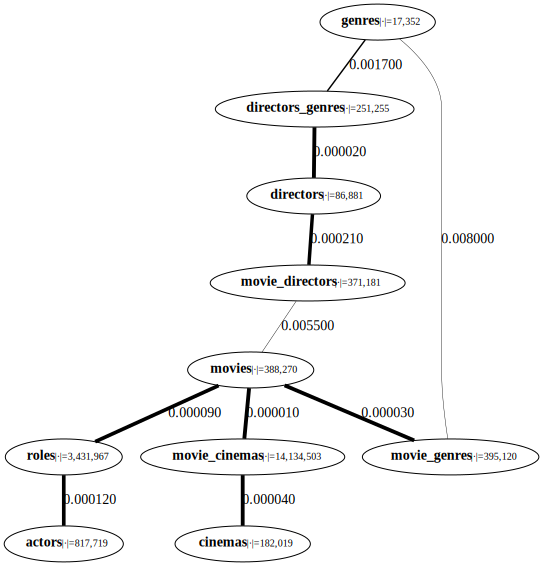

In [5]:
imdb_graph = JoinGraph()

imdb_graph.add_relation('genres', 17_352)
imdb_graph.add_relation('directors_genres', 251_255)
imdb_graph.add_relation('directors', 86_881)
imdb_graph.add_relation('movie_directors', 371_181)
imdb_graph.add_relation('movies', 388_270)
imdb_graph.add_relation('movie_genres', 395_120)
imdb_graph.add_relation('roles', 3_431_967)
imdb_graph.add_relation('actors', 817_719)
imdb_graph.add_relation('movie_cinemas', 14_134_503)
imdb_graph.add_relation('cinemas', 182_019)

imdb_graph.add_join(0.00170,  'genres', 'directors_genres')
imdb_graph.add_join(0.00002, 'directors_genres', 'directors')
imdb_graph.add_join(0.00021, 'directors', 'movie_directors')
imdb_graph.add_join(0.00550, 'movie_directors', 'movies')
imdb_graph.add_join(0.00003, 'movies', 'movie_genres')
imdb_graph.add_join(0.00800, 'movie_genres', 'genres')
imdb_graph.add_join(0.00009, 'movies', 'roles')
imdb_graph.add_join(0.00012, 'roles', 'actors')
imdb_graph.add_join(0.00001, 'movies', 'movie_cinemas')
imdb_graph.add_join(0.00004, 'movie_cinemas', 'cinemas')

draw_join_graph(imdb_graph)


## Pruning the Search Space of Plan Enumeration

Instead of computing the costs for each possible join plan, one can also first compute the costs (and sizes) of partial plans. If you then find a partial plan containing the same relations as another one, but with higher costs, you can safely ignore it, thus reducing the search space for the plan enumeration.


### Exercise for assignment sheet 6

Improve over exhaustive plan enumeration by disregarding partial plans that contain the same relations as another one, but would result in higher costs.
* In your implementation, you should use a dynamic programming approach similar to how it was done in Exercise 2. Therefore, you first need to calculate the optimal join plans (and respective costs and output sizes) for joins of size n. After that, you need to store these values and use them to compute the best join plans (and respective costs and output sizes) for joins of size m > n.
* You must consider bushy plans in your implementation (and thus also left-deep and right-deep plans). You may assume that the join graph is always a [connected graph](https://en.wikipedia.org/wiki/Connectivity_(graph_theory)). 
* You only need to consider symmetric cost functions.
* Use the function `compute_cost_and_size()` to compute the cost, as well as the result size of a join. Please note, that the returned cost already contains the recursive costs of the left and right input.
* The join plans (the output of `find_cheapest_plan_with_pruning()`, as well as the input for `compute_cost_and_size()`) must follow a specific structure. In particular, each plan is encoded using nested [tuples](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences). For example, the plan ((A ⋈ B) ⋈ (C ⋈ D)) ⋈ E is defined as: 
````py
plan = (((A,B),(C,D)),E) # `plan` is of type tuple
````
* `find_cheapest_plan_with_pruning()` should output a tuple containing the final join plan, together with the costs of the complete join. 
* Note that our reference implementation takes less than one second for the computation of the complex IMDb example. Your implementation should take roughly the same time.

In [6]:
def draw_query_plan_bushy(plan):
    G = gv.Graph(name='query_plan', comment='The Query Plan')
    G.graph_attr['rankdir'] = 'BT'

    relations = get_relations_from_plan(plan)
    # Add the Relations as leaves.
    for tbl in relations:
        G.node(tbl, f'<<B>{tbl}</B>>')
        
    joins = 1
    
    def draw_plan_rec(plan, G):
        nonlocal joins
        if isinstance(plan[0], tuple):
            left = draw_plan_rec(plan[0], G)
        else:
            left = plan[0]

        for i in range(1, len(plan)):
            if isinstance(plan[i], tuple):
                right = draw_plan_rec(plan[i], G)
            else:
                right = plan[i]

            G.node(str(joins), '⋈')
            G.edge(left, str(joins))
            G.edge(right, str(joins))
            left = str(joins)
            joins += 1

        return left
        

    draw_plan_rec(plan, G)
    return G



def get_relations_from_plan(plan):
    
    relation = []
    if not isinstance(plan, tuple):
        return [plan]
    for element in plan:
        if isinstance(element, tuple):
            relation += get_relations_from_plan(element)
        else:
            relation.append(element)
    
    return relation
            

In [7]:
def compute_cost_and_size(left_input, right_input, join_graph, cost_fn):
    """Computes the cost and the size of joining the left input with the right input.

    Args:
        left_input    (:obj: `tuple`):         A tuple containing the join plan, the costs and the size of the left input: 
                                               (join_plan, costs, size).
        right_input   (:obj: `tuple`):         A tuple containing the join plan, the costs and the size of the right input:
                                               (join_plan, costs, size)
        join_graph    (:obj: `JoinGraph`):     The join graph.
        cost_fn       (:obj: `CostFunctions`): The cost function.

    Returns:
        (:obj: `tuple`): Returns a tuple containing the cost and size of joining the left input with the right input,
                         including the recursive costs of the left and right input.
    """
    left_relations = get_relations_from_plan(left_input[0])
    right_relations = get_relations_from_plan(right_input[0])
    joined = set(left_relations)
    
    selectivity = 1
    for relation in right_relations:
        for J in join_graph.joins:
            if relation in J.relation_names and len(joined.intersection(J.relation_names)) != 0:
                selectivity *= J.selectivity
      
    cost = cost_fn(left_input[2], right_input[2], selectivity) + left_input[1] + right_input[1]
    size = round(selectivity * left_input[2] * right_input[2])
    
    return (cost, size)

In [8]:
def find_cheapest_plan_with_pruning(join_graph, cost_fn):
    """Find the cheapest join plan, without considering suboptimal subplans.

    Args:
        join_graph  (:obj: `JoinGraph`):     The join graph.
        cost_fn     (:obj: `CostFunctions`): The cost function.

    Returns:
        (:obj: `tuple`): Returns a tuple containing the cheapest plan, as well its respective cost.
    """
    # Add your code here!!
    # Extract the relation names
    relations = [R.name for R in join_graph.named_relations.values()]

    least_cost = math.inf
    cheapest_plan = None
    
    
    
    return (cheapest_plan, cost)

Below you can find a sample solution of the resulting join plan, together with the respective costs. Keep in mind that because of the symmetry, there are multiple valid plans (but not costs!).

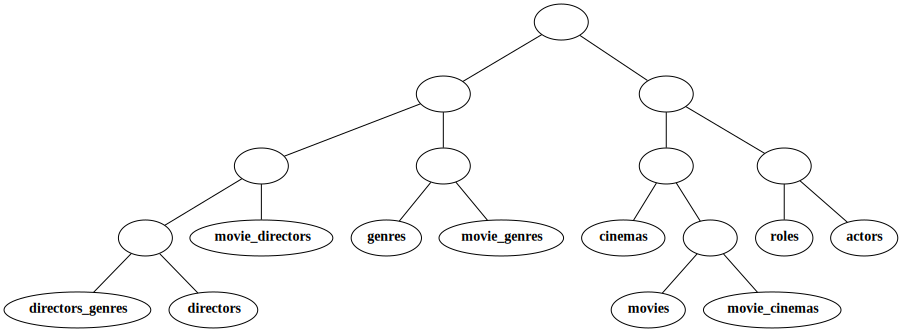

The cheapest plan is (((('directors_genres', 'directors'), 'movie_directors'), ('genres', 'movie_genres')), ((('movies', 'movie_cinemas'), 'cinemas'), ('roles', 'actors'))) with cost 15,284,562,153,721.


In [9]:
plan = (((('directors_genres', 'directors'), 'movie_directors'), ('genres', 'movie_genres')), ((('movies', 'movie_cinemas'), 'cinemas'), ('roles', 'actors')))
cost = 15284562153721
display(draw_query_plan_bushy(plan))
print(f'The cheapest plan is {plan} with cost {cost:,}.')

Use the following cell to test your implementation.

TypeError: cannot unpack non-iterable NoneType object

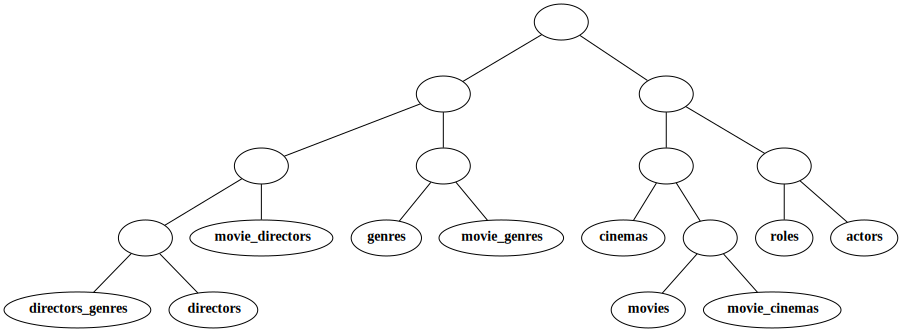

The cheapest plan is (((('directors_genres', 'directors'), 'movie_directors'), ('genres', 'movie_genres')), ((('movies', 'movie_cinemas'), 'cinemas'), ('roles', 'actors'))) with cost 15,284,562,153,721.


In [10]:
%time (plan, cost) = find_cheapest_plan_with_pruning(imdb_graph, CostFunctions.size_of_inputs)
display(draw_query_plan_bushy(plan))
print(f'The cheapest plan is {plan} with cost {cost:,}.')